# **Project Car Formula**

Based on a fast neural network architecture, our car make recognition module can be easily integrated into applications that require accurate tagging of car images. It is robust under different lighting conditions and different angles. It can operate on embedded hardware, on-premise servers or can be deployed as cloud API.

There are lots of industries that could benefit from our car recognition module, including security, marketing and law enforcement.

This notebook will mainly perform data cleaning and preprocessing in order to prepare and format the dataset for use with various tensorflow keras CNN architectures.

##### First, we load the libraries required for this job.

In [1]:
# IGNORE ALL WARNINGS
import warnings
warnings.filterwarnings('ignore')

# STANDARD LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# FILE MANIPULATION
from scipy.io import loadmat
import os
import random
import cv2

# UTILITIES
from tqdm.notebook import tqdm

##### We need to read the matlab file to get the image names and targets. After analysing the shape, it is clear that there are a total of 16185 images of beautiful cars inside this dataset. This consists of 8144 training images and 8041 test images. 

In [2]:
path_to_train_matfile = 'devkit/cars_train_annos.mat'
raw_train_data = loadmat(path_to_train_matfile)
path_to_test_matfile = 'devkit/cars_test_annos_withlabels.mat'
raw_test_data = loadmat(path_to_test_matfile)
train_annots_data = np.transpose(raw_train_data["annotations"])
test_annots_data = np.transpose(raw_test_data["annotations"])
print(train_annots_data.shape)
print(test_annots_data.shape)


(8144, 1)
(8041, 1)


##### Let us count how many different car makes are there in total? : 196

In [3]:
unique_make_list = []
for i in train_annots_data:
    if i[0][4][0][0] not in unique_make_list:
        unique_make_list.append(i[0][4][0][0])
len(unique_make_list)

196

##### Create working directories seperate from the ones given to us, it will be stored in cwd/working/data/...

In [4]:
if not os.path.exists('working/data/train'):
    os.makedirs('working/data/train', 777)
if not os.path.exists('working/data/test'):
    os.makedirs('working/data/test', 777)
img_height = 224
img_width = 224

##### Make a function to format all training images into directories of their car makes, and crop all images according to bounding box dimensions.

In [5]:
def format_train_data(rev_paths, labels, bounding_boxes, samples, toshuffle):
    print("Dumping training images, relax.")
    imagedir ='cars_train/cars_train/'
    if toshuffle:
        indexlist = [f for f in range(samples)]
        random.shuffle(indexlist)
        chosen_method = indexlist
    else:
        chosen_method = range(samples)
    for i in tqdm(chosen_method):
        rev_path = rev_paths[i]
        label = labels[i]
        (x1, y1, x2, y2) = bounding_boxes[i]
        raw_path = os.path.join(imagedir, rev_path)
        myimage = cv2.imread(raw_path)
        h, w = myimage.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, w)
        y2 = min(y2 + margin, h)
        dst_folder = 'working/data/train'
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, rev_path)
        cropped_image = myimage[y1:y2, x1:x2]
        dst_img = cv2.resize(src=cropped_image, dsize=(img_height, img_width))
        cv2.imwrite(dst_path, dst_img)

##### Make a function to format all test images into directories of their car makes, and crop all images according to bounding box dimensions.

In [6]:
def format_test_data(rev_paths, labels, bounding_boxes, samples, myratio, toshuffle):
    print("Dumping test images, patient there.")
    src_folder = 'cars_test/cars_test/'
    dst_folder = 'working/data/test'
    total_image_count = 16180
    testimages_count = (1 - myratio) * total_image_count
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    if toshuffle:
        indexlist = [f for f in range(samples)]
        random.shuffle(indexlist)
        chosen_method = indexlist
    else:
        chosen_method = range(samples)
    for i in tqdm(chosen_method):
        rev_path = rev_paths[i]
        label = labels[i]
        (x1, y1, x2, y2) = bounding_boxes[i]
        raw_path = os.path.join(src_folder, rev_path)
        myimage = cv2.imread(raw_path)
        h, w = myimage.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, w)
        y2 = min(y2 + margin, h)
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, rev_path)
        cropped_image = myimage[y1:y2, x1:x2]
        dst_img = cv2.resize(src=cropped_image, dsize=(img_height, img_width))
        if i < testimages_count:
            cv2.imwrite(dst_path, dst_img)
        else:
            rerouted_train_dst_path = os.path.join('working/data/train/', label)
            rerouted_train_dst_path = os.path.join(rerouted_train_dst_path, rev_path)
            cv2.imwrite(rerouted_train_dst_path, dst_img)

##### This is the main function which will initiate loading of training, validation and test images into the working directories.

In [7]:
def load_data(test, trainingratio, shuffled):
    if test:
        print("Loading test images")
        bounding_boxes, makes, image_relative_paths, labels = [], [], [], []
        for annotation in tqdm(test_annots_data):
            bbox_x1 = annotation[0][0][0][0]
            bbox_y1 = annotation[0][1][0][0]
            bbox_x2 = annotation[0][2][0][0]
            bbox_y2 = annotation[0][3][0][0]
            make_id = annotation[0][4][0][0]
            image_relative_path = annotation[0][5][0]
            labels.append('%04d' % (make_id,))
            bounding_boxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
            makes.append(make_id)
            image_relative_paths.append(image_relative_path)
        samples = len(image_relative_paths)
        format_test_data(image_relative_paths, labels, bounding_boxes, samples, trainingratio, shuffled)
    else:
        print("Loading train images")
        bounding_boxes, makes, image_relative_paths, labels = [], [], [], []
        for annotation in tqdm(train_annots_data):
            bbox_x1 = annotation[0][0][0][0]
            bbox_y1 = annotation[0][1][0][0]
            bbox_x2 = annotation[0][2][0][0]
            bbox_y2 = annotation[0][3][0][0]
            make_id = annotation[0][4][0][0]
            image_relative_path = annotation[0][5][0]
            labels.append('%04d' % (make_id,))
            bounding_boxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
            makes.append(make_id)
            image_relative_paths.append(image_relative_path)
        samples = len(image_relative_paths)
        format_train_data(image_relative_paths, labels, bounding_boxes, samples, shuffled)

##### How a typical car name label looks like. I will generate a random car image and its make.

Chevrolet Monte Carlo Coupe 2007


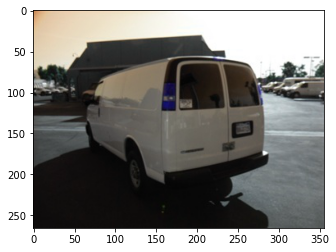

In [8]:
random_index = random.randint(0, 8144)
training_path = 'cars_train/cars_train/'
relative_path = (train_annots_data[random_index,:])[0][5][0]
random_car = cv2.imread(os.path.join(training_path, relative_path))
plt.imshow(random_car)
path_to_labels_matfile = 'devkit/cars_meta.mat'
raw_labels_data = loadmat(path_to_labels_matfile)
print(raw_labels_data["class_names"][0][(train_annots_data[random_index,:])[0][4][0][0]][0])

##### These 2 function calls will set up the loading process. Functions are used so that the memory in the RAM is freed up after returning from the stack. 

In [9]:
if __name__ == "__main__":
    train_to_test_ratio = 0.5               # TRAINING SET RATIO, PUT DECIMAL HERE
    additional_shuffling = True             # To SHUFFLE TRAINING AND TEST IMAGES ORDER
    
    # 0 for Train, 1 for Test
    load_data(0, train_to_test_ratio, additional_shuffling)
    load_data(1, train_to_test_ratio, additional_shuffling)

Loading train images



Dumping training images, relax.



Loading test images



Dumping test images, patient there.


### Now that image preprocessing and directories are properly set up, we can now move onto model building with Keras. 